# Michelin Rated Restaurants in France

In [1]:
# Module import (comprehensive for entire notebook)
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
import mapclassify
import folium
import branca

----
&nbsp;
## Import the French dataset

In [2]:
france = pd.read_csv("../../data/France/france_data.csv")
france.head()

,name,address,city,country,price,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,France,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,"Hameau de Saint-Marcel, Saint-Martin-de-Belle...",Saint-Martin-de-Belleville,France,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,"5 avenue Saint-Victor, Fontjoncouse, 11360, Fr...",Fontjoncouse,France,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,"Larsiallas, Saint-Bonnet-le-Froid, 43290, France",Saint-Bonnet-le-Froid,France,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


In [3]:
print(f"Unique Cities: {len(france['city'].unique())}")

Unique Cities: 618


----
&nbsp;
## Ordinal encoding of the `price` column

In [4]:
france['price'].unique().tolist()

['€€€€', '€€€', '€€', '€']

In [5]:
price_mapping = {'€': 1, '€€': 2, '€€€': 3, '€€€€': 4}
france['price_num'] = france['price'].map(price_mapping)

cols = france.columns.tolist()
# Find the index of the 'price' column
price_index = cols.index('price')

# Insert 'price_num' into the correct position in the column list
cols.insert(price_index + 1, cols.pop(cols.index('price_num')))

# Reindex the dataframe
france_data = france[cols]

In [6]:
france_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1039 non-null   object 
 1   address    1039 non-null   object 
 2   city       1039 non-null   object 
 3   country    1039 non-null   object 
 4   price      1039 non-null   object 
 5   price_num  1039 non-null   int64  
 6   cuisine    1039 non-null   object 
 7   url        995 non-null    object 
 8   award      1039 non-null   object 
 9   stars      1039 non-null   float64
 10  longitude  1039 non-null   float64
 11  latitude   1039 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 97.5+ KB


----
&nbsp;
## Location Visualisation

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

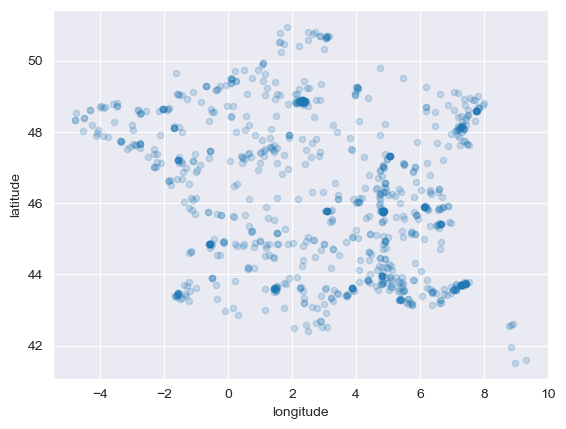

In [7]:
france_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2)

The datapoints trace the map of France quite well!

There are clusters in the Côte d'Azur, following the Rhone and in Paris

In [8]:
# Filter the data
filtered_france_data = france_data[france_data['stars'] != 0.5]

# Create a color map
colormap = branca.colormap.StepColormap(colors=['lightblue','yellow', 'red'],
                                          index=[0,1,2,3], # Define the index for the colors
                                          vmin=0,
                                          vmax=3)

# Create a map centered around the UK
france_map = folium.Map(location=[46.603354, 1.888334], tiles='Stamen Terrain', zoom_start=6)

# Add a legend
colormap.caption = 'Michelin Stars'
france_map.add_child(colormap)

# Add a marker for each point in your data
for idx, row in filtered_france_data.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=colormap(row['stars']),  # Use the 'stars' value to determine the color
        fill=True,
        fill_opacity=0.1  # Control the opacity here
    ).add_to(france_map)

# Add the color map legend to the map
colormap.add_to(france_map)

# Display the map (This is commented out)
#france_map

Static image of the above plot.

Running in own Jupyter environment allows interactivity

![img](../../Images/Static_france.png)

----
&nbsp;
## Partitioning the data regionally.

#### Creating new columns `department` & `region`

We import the `departments.csv` data which was created in `Data_preparation.ipynb`

In [9]:
departments = pd.read_csv("../../data/France/departments.csv")
departments.head()

,department_num,department,region
0,01,Ain,Auvergne-Rhône-Alpes
1,02,Aisne,Hauts-de-France
2,03,Allier,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur


We first check the French data for the format of addresses in Monaco

In [10]:
monaco = france_data[france_data['city'] == 'Monaco']
monaco

,name,address,city,country,price,price_num,cuisine,url,award,stars,longitude,latitude
16,Le Louis XV - Alain Ducasse à l'Hôtel de Paris,"Place du Casino, Monaco, 98000, France",Monaco,France,€€€€,4,"Mediterranean Cuisine, Modern Cuisine",https://www.ducasse-paris.com/,3 MICHELIN Stars,3.0,7.427105,43.739184
75,Le Blue Bay,"40 avenue Princesse-Grace, Monaco, 98000, France",Monaco,France,€€€€,4,Creative,https://www.montecarlosbm.com/fr/restaurant-mo...,2 MICHELIN Stars,2.0,7.437975,43.748897
409,Le Grill,"Place du Casino, Monaco, 98000, France",Monaco,France,€€€€,4,Classic Cuisine,https://www.montecarlosbm.com/fr/restaurant-mo...,1 MICHELIN Star,1.0,7.427100,43.739367
426,Yoshi,"4 avenue de la Madone, Monaco, 98000, France",Monaco,France,€€€€,4,Japanese,http://www.metropole.com/fr,1 MICHELIN Star,1.0,7.427975,43.740818
455,"Pavyllon, un restaurant de Yannick Alléno, Mon...","Square Beaumarchais, Monaco, 98000, France",Monaco,France,€€€€,4,"Modern Cuisine, Creative",https://www.montecarlosbm.com/fr,1 MICHELIN Star,1.0,7.425868,43.738462
489,La Table d'Antonio Salvatore au Rampoldi,"3 avenue des Spélugues, Monaco, 98000, France",Monaco,France,€€€€,4,"Italian, Creative",http://www.rampoldi.mc/la-table-dantonio-salva...,1 MICHELIN Star,1.0,7.427820,43.740456


We create a copy and extract the first two digits of code postal in `address`

In [11]:
france_data = france_data.copy()
france_data['department_num'] = france_data['address'].str.extract(r'(\b\d{5}\b)', expand=False).str[:2]

#### We now merge `france_data` and `departments` on `department_num`

In [12]:
france_data = france_data.merge(departments, on='department_num', how='left')
print(france_data.columns.tolist())

['name', 'address', 'city', 'country', 'price', 'price_num', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude', 'department_num', 'department', 'region']


In [13]:
france_data = france_data[['name', 'address', 'city', 'department_num', 'department', 'region', 'country',
                           'price', 'price_num', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']]
france_data.head()

,name,address,city,department_num,department,region,country,price,price_num,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,83,Var,Provence-Alpes-Côte d'Azur,France,€€€€,4,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,"Hameau de Saint-Marcel, Saint-Martin-de-Belle...",Saint-Martin-de-Belleville,73,Savoie,Auvergne-Rhône-Alpes,France,€€€€,4,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,75,Paris,Île-de-France,France,€€€€,4,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,"5 avenue Saint-Victor, Fontjoncouse, 11360, Fr...",Fontjoncouse,11,Aude,Occitanie,France,€€€€,4,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,"Larsiallas, Saint-Bonnet-le-Froid, 43290, France",Saint-Bonnet-le-Froid,43,Haute-Loire,Auvergne-Rhône-Alpes,France,€€€€,4,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


We now create 2 more dataframes; `paris` and `rest_of_france`

In [14]:
paris = france_data[france_data['city'] == 'Paris']
rest_of_france = france_data[france_data['city'] != 'Paris']

In [15]:
paris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 2 to 1026
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            159 non-null    object 
 1   address         159 non-null    object 
 2   city            159 non-null    object 
 3   department_num  159 non-null    object 
 4   department      159 non-null    object 
 5   region          159 non-null    object 
 6   country         159 non-null    object 
 7   price           159 non-null    object 
 8   price_num       159 non-null    int64  
 9   cuisine         159 non-null    object 
 10  url             153 non-null    object 
 11  award           159 non-null    object 
 12  stars           159 non-null    float64
 13  longitude       159 non-null    float64
 14  latitude        159 non-null    float64
dtypes: float64(3), int64(1), object(11)
memory usage: 19.9+ KB


#### We may further sub-divide paris by arrondissements. Only `url` has missing values

In [16]:
rest_of_france.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 0 to 1038
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            880 non-null    object 
 1   address         880 non-null    object 
 2   city            880 non-null    object 
 3   department_num  880 non-null    object 
 4   department      868 non-null    object 
 5   region          868 non-null    object 
 6   country         880 non-null    object 
 7   price           880 non-null    object 
 8   price_num       880 non-null    int64  
 9   cuisine         880 non-null    object 
 10  url             842 non-null    object 
 11  award           880 non-null    object 
 12  stars           880 non-null    float64
 13  longitude       880 non-null    float64
 14  latitude        880 non-null    float64
dtypes: float64(3), int64(1), object(11)
memory usage: 110.0+ KB


#### `rest_of_france` has some null values for `department` and `region`

In [17]:
# Select rows where 'department' and 'region' are NaN
rest_of_france_null = france_data[(france_data['department'].isnull()) & (france_data['region'].isnull())]
rest_of_france_null

,name,address,city,department_num,department,region,country,price,price_num,cuisine,url,award,stars,longitude,latitude
16,Le Louis XV - Alain Ducasse à l'Hôtel de Paris,"Place du Casino, Monaco, 98000, France",Monaco,98,NaN,NaN,France,€€€€,4,"Mediterranean Cuisine, Modern Cuisine",https://www.ducasse-paris.com/,3 MICHELIN Stars,3.0,7.427105,43.739184
39,Casadelmar,"7 km par route de la plage de Palombaggia, Por...",Porto-Vecchio,20,NaN,NaN,France,€€€€,4,Modern Cuisine,https://www.casadelmar.fr/fr/,2 MICHELIN Stars,2.0,9.309977,41.594810
75,Le Blue Bay,"40 avenue Princesse-Grace, Monaco, 98000, France",Monaco,98,NaN,NaN,France,€€€€,4,Creative,https://www.montecarlosbm.com/fr/restaurant-mo...,2 MICHELIN Stars,2.0,7.437975,43.748897
249,A Casa di Ma,"Route de Calvi, Lumio, 20260, France",Lumio,20,NaN,NaN,France,€€€€,4,Modern Cuisine,https://www.acasadima.com/,1 MICHELIN Star,1.0,8.831886,42.581304
279,La Table de la Ferme,"Vallée de l'Ortolo, domaine de Murtoli, Murtol...",Murtoli,20,NaN,NaN,France,€€€€,4,"Modern Cuisine, Corsican",https://www.murtoli.com/,1 MICHELIN Star,1.0,8.946903,41.522976
409,Le Grill,"Place du Casino, Monaco, 98000, France",Monaco,98,NaN,NaN,France,€€€€,4,Classic Cuisine,https://www.montecarlosbm.com/fr/restaurant-mo...,1 MICHELIN Star,1.0,7.427100,43.739367
426,Yoshi,"4 avenue de la Madone, Monaco, 98000, France",Monaco,98,NaN,NaN,France,€€€€,4,Japanese,http://www.metropole.com/fr,1 MICHELIN Star,1.0,7.427975,43.740818
455,"Pavyllon, un restaurant de Yannick Alléno, Mon...","Square Beaumarchais, Monaco, 98000, France",Monaco,98,NaN,NaN,France,€€€€,4,"Modern Cuisine, Creative",https://www.montecarlosbm.com/fr,1 MICHELIN Star,1.0,7.425868,43.738462
489,La Table d'Antonio Salvatore au Rampoldi,"3 avenue des Spélugues, Monaco, 98000, France",Monaco,98,NaN,NaN,France,€€€€,4,"Italian, Creative",http://www.rampoldi.mc/la-table-dantonio-salva...,1 MICHELIN Star,1.0,7.427820,43.740456
525,La Signoria,"Route de la Forêt-de-Bonifato, Calvi, 20260, F...",Calvi,20,NaN,NaN,France,€€€€,4,Modern Cuisine,https://www.hotel-la-signoria.com/,1 MICHELIN Star,1.0,8.784631,42.536832


`department_num` 20 represents Corsica. 98 represents Monaco

Strictly there are two departments for Corse; 2A and 2B. However, this level of detail is not required

In [18]:
# Filter rows where 'department_num' is 20
france_data.loc[france_data['department_num'] == '20', 'department'] = 'Corse'
france_data.loc[france_data['department_num'] == '20', 'region'] = 'Corse'

# Filter rows where 'department_num' is 98
france_data.loc[france_data['department_num'] == '98', 'department'] = 'Monaco'
france_data.loc[france_data['department_num'] == '98', 'region'] = 'Monaco'

# We split by city != Paris again
rest_of_france = france_data[france_data['city'] != 'Paris']

In [19]:
rest_of_france.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 0 to 1038
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            880 non-null    object 
 1   address         880 non-null    object 
 2   city            880 non-null    object 
 3   department_num  880 non-null    object 
 4   department      880 non-null    object 
 5   region          880 non-null    object 
 6   country         880 non-null    object 
 7   price           880 non-null    object 
 8   price_num       880 non-null    int64  
 9   cuisine         880 non-null    object 
 10  url             842 non-null    object 
 11  award           880 non-null    object 
 12  stars           880 non-null    float64
 13  longitude       880 non-null    float64
 14  latitude        880 non-null    float64
dtypes: float64(3), int64(1), object(11)
memory usage: 110.0+ KB


Again, `url` has some missing values.

The data is cleaned, split and ready for further analysis

----
&nbsp;
## Importing `demographics.csv` data

In [20]:
demographics = pd.read_csv("../../data/France/demographics.csv")

In [21]:
demographics.head()

,department_num,department,region,population,population_density,area_sq_km
0,01,Ain,Auvergne-Rhône-Alpes,652432,114.2,5713.06
1,02,Aisne,Hauts-de-France,531345,71.9,7390.06
2,03,Allier,Auvergne-Rhône-Alpes,335975,45.7,7351.75
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,164308,23.9,6874.81
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,141220,25.3,5581.82


To visualise the demographics data, we require a GeoJSON file of the departmental boundaries of metropolitan France

Credit: [gregoiredavid.github](https://github.com/gregoiredavid/france-geojson)

In [22]:
# Load the GeoJSON file
gdf = gpd.read_file('../../data/France/departements.geojson')
gdf.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


We can join the geoJSON data on `code` and delete the `nom` column

In [23]:
# Merge dataframes
merged = gdf.set_index('code').join(demographics.set_index('department_num'))

# Delete 'nom' column in place
merged.drop(columns='nom', inplace=True)

print(len(merged))
merged.head()

96


,geometry,department,region,population,population_density,area_sq_km
code,,,,,,
01,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",Ain,Auvergne-Rhône-Alpes,652432,114.2,5713.06
02,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",Aisne,Hauts-de-France,531345,71.9,7390.06
03,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...",Allier,Auvergne-Rhône-Alpes,335975,45.7,7351.75
04,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,164308,23.9,6874.81
05,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",Hautes-Alpes,Provence-Alpes-Côte d'Azur,141220,25.3,5581.82


### Creating Visualisation of `population` & `population_density`

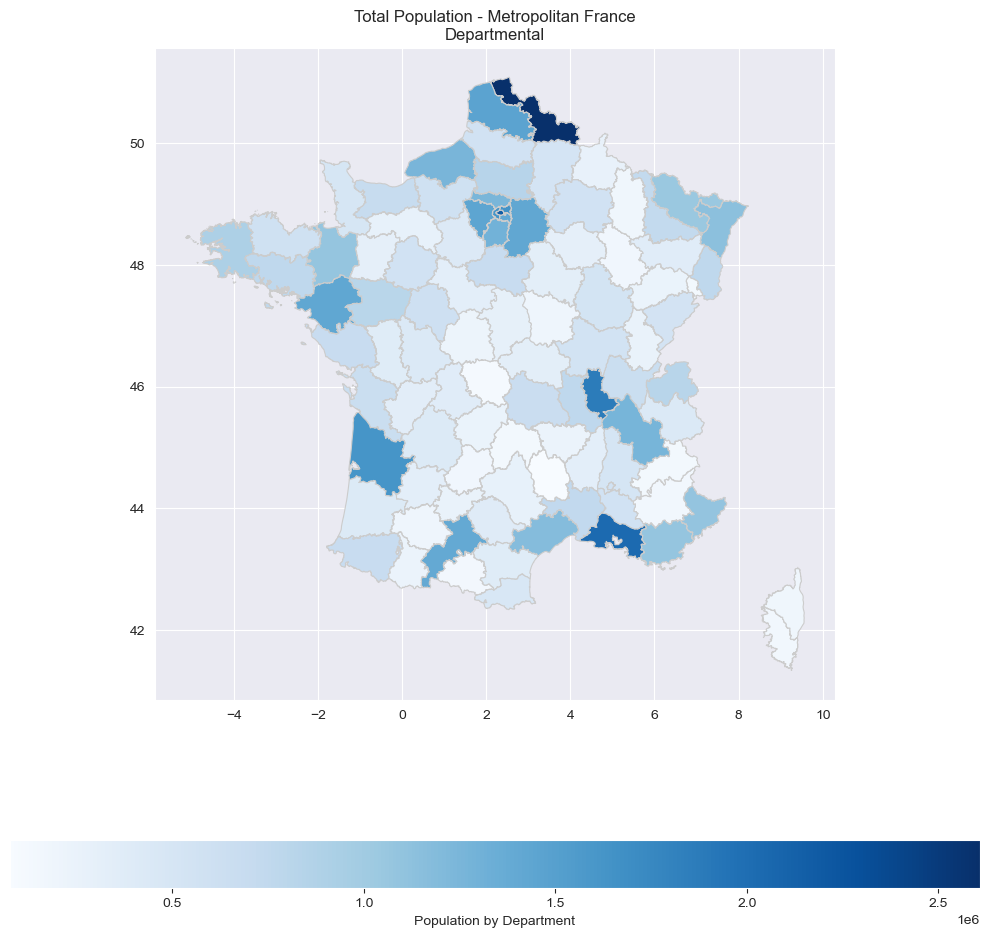

In [24]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create map
merged.plot(column='population',
            cmap='Blues',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True,
            legend_kwds={'label': "Population by Department",
                         'orientation': "horizontal"})
plt.title("Total Population - Metropolitan France\nDepartmental")
plt.tight_layout()
plt.show()

#### There's a huge range of values in `population_density`

We apply a log transformation and bin by 'natural breaks' in the data

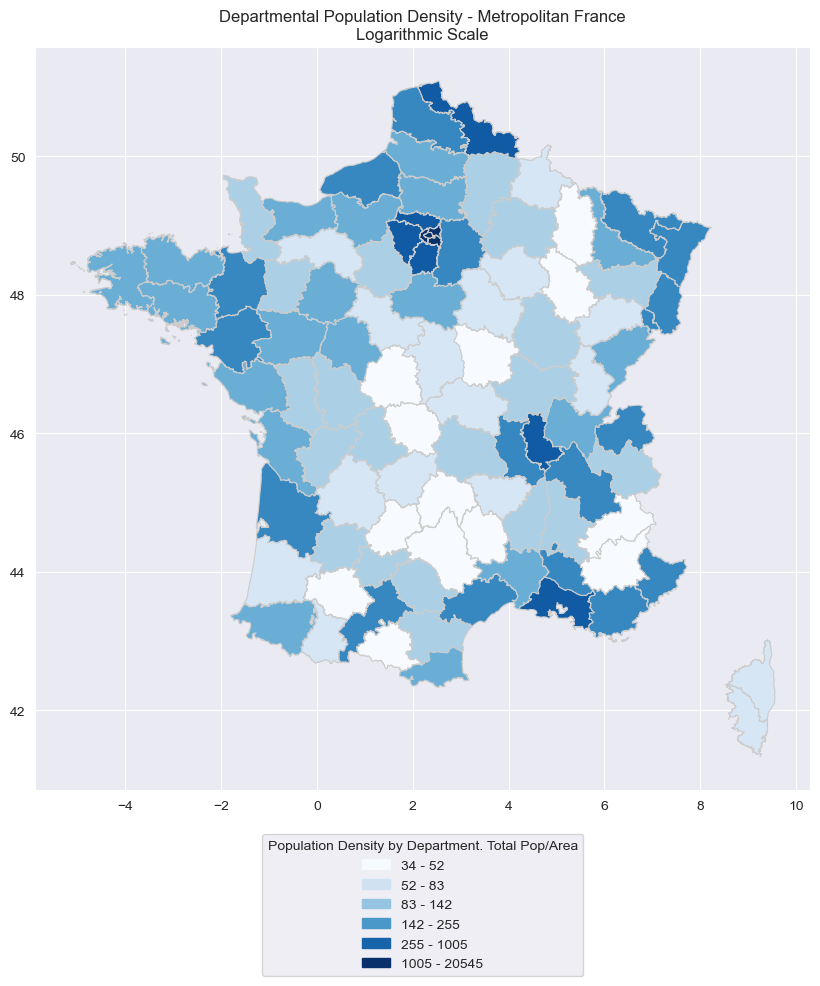

In [25]:
# Apply log transformation to the density column
merged['log_population_density'] = np.log(merged['population_density'] + 1)  # Add 1 or a small constant to avoid log(0)
# Define classification scheme
classifier = mapclassify.NaturalBreaks(merged['log_population_density'], k=7)  # Using NaturalBreaks
# Apply classification to dataframe
merged['classification'] = merged[['log_population_density']].apply(classifier)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create map
merged.plot(column='classification',
            cmap='Blues',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=False) # we will create a custom legend

# Create legend
labels = []
# Create a list of bin boundaries in original scale
bin_edges_exp = np.exp(classifier.bins) - 1
for i in range(len(bin_edges_exp) - 1):
    label = f"{bin_edges_exp[i]:.0f} - {bin_edges_exp[i+1]:.0f}"
    labels.append(mpatches.Patch(color=plt.cm.Blues(i / (len(bin_edges_exp) - 2)),
                                 label=label))
plt.legend(handles=labels,
           title='Population Density by Department. Total Pop/Area',
           bbox_to_anchor=(0.5, -0.05),
           loc='upper center')
plt.title("Departmental Population Density - Metropolitan France\nLogarithmic Scale")
plt.show()

----
&nbsp;
## Number of Michelin Rated Restaurants by Region

In [26]:
print(f"Michelin Rated Restaurants\nAll France: {len(france_data)}")

Michelin Rated Restaurants
All France: 1039


In [27]:
print(f"Michelin Rated Restaurants\nParis: {len(paris)}")

Michelin Rated Restaurants
Paris: 159


----
&nbsp;
### Analysis of Michelin Stars by department and region

#### `top_restaurants_by_department` function

Imported below and defined in `functions.py`. The function analyses a dataset of restaurants and outputs the top $n$ departments with the highest count of restaurants with a specified Michelin star rating.

Usage:
```python
top_restaurants_by_department(data, star_rating, top_n, display_restaurants=True)
```
----
&nbsp;
`data` is a pandas DataFrame that contains restaurant information. It expects the following columns: 'department', 'stars', 'name', 'city', and 'department_num'.

`star_rating` is an integer (1, 2, or 3) specifying the Michelin star rating of interest.

`top_n` is an integer specifying the number of top departments to consider.

`display_restaurants` is an optional boolean flag. When set to True (default), the function also prints the names and cities of the top restaurants.

In [28]:
from functions import top_restaurants_by_department

In [29]:
# excludes Paris
top_restaurants_by_department(rest_of_france, 3, 3)

Top 3 departments with most ⭐⭐⭐ restaurants:


Department: Bouches-du-Rhône: 13
4 ⭐⭐⭐ Restaurants

Restaurant: La Villa Madie
Location: Cassis

Restaurant: L'Oustau de Baumanière
Location: Les Baux-de-Provence

Restaurant: Le Petit Nice
Location: Marseille

Restaurant: AM par Alexandre Mazzia
Location: Marseille



Department: Savoie: 73
2 ⭐⭐⭐ Restaurants

Restaurant: René et Maxime Meilleur
Location: Saint-Martin-de-Belleville

Restaurant: Le 1947 à Cheval Blanc
Location: Courchevel



Department: Haute-Savoie: 74
2 ⭐⭐⭐ Restaurants

Restaurant: Le Clos des Sens
Location: Annecy

Restaurant: Flocons de Sel
Location: Megève





In [30]:
# We specify 'top5' however, the paris dataset has 1 department; 75
top_restaurants_by_department(paris, 2, 5)

⭐⭐ Restaurants in Paris

Department: Paris: 75
15 ⭐⭐ Restaurants

Restaurant: Maison Rostang
Location: Paris

Restaurant: Table - Bruno Verjus
Location: Paris

Restaurant: Le Grand Restaurant - Jean-François Piège
Location: Paris

Restaurant: Sur Mesure par Thierry Marx
Location: Paris

Restaurant: Guy Savoy
Location: Paris

Restaurant: Le Gabriel - La Réserve Paris
Location: Paris

Restaurant: Le Taillevent
Location: Paris

Restaurant: Palais Royal Restaurant
Location: Paris

Restaurant: Marsan par Hélène Darroze
Location: Paris

Restaurant: David Toutain
Location: Paris

Restaurant: L'Abysse au Pavillon Ledoyen
Location: Paris

Restaurant: L'Oiseau Blanc
Location: Paris

Restaurant: Le Clarence
Location: Paris

Restaurant: La Scène
Location: Paris

Restaurant: Restaurant Le Meurice Alain Ducasse
Location: Paris





#### `top_restaurants_by_region` function

Again, defined in `functions.py`, it analyses a dataset of restaurants and outputs the top $n$ departments with the highest count of restaurants with a specified Michelin star rating. This iteration allows the argument 'all' for `star_rating`

In [31]:
from functions import top_restaurants_by_region

In [32]:
# For brevity, the display_restaurants flag is set False
# We run on France data which includes Paris
# Using 'all' parameter
top_restaurants_by_region(france_data, 'all', 5, display_restaurants=False)

Top 5 regions with most starred restaurants:


Region: Île-de-France
134 Starred Restaurants

9 ⭐⭐⭐ Restaurants

15 ⭐⭐ Restaurants

110 ⭐ Restaurants



Region: Auvergne-Rhône-Alpes
95 Starred Restaurants

8 ⭐⭐⭐ Restaurants

15 ⭐⭐ Restaurants

72 ⭐ Restaurants



Region: Provence-Alpes-Côte d'Azur
77 Starred Restaurants

6 ⭐⭐⭐ Restaurants

5 ⭐⭐ Restaurants

66 ⭐ Restaurants



Region: Nouvelle-Aquitaine
57 Starred Restaurants

1 ⭐⭐⭐ Restaurant

7 ⭐⭐ Restaurants

49 ⭐ Restaurants



Region: Grand Est
51 Starred Restaurants

1 ⭐⭐⭐ Restaurant

9 ⭐⭐ Restaurants

41 ⭐ Restaurants





----
&nbsp;
## Grouping restaurants by `department` and `region` based on the number of Michelin stars.

In [33]:
france_data = france_data.copy()

# Create dummy variables for each category of 'stars'
france_data['1_star'] = france_data['stars'].apply(lambda x: 1 if x == 1.0 else 0)
france_data['2_star'] = france_data['stars'].apply(lambda x: 1 if x == 2.0 else 0)
france_data['3_star'] = france_data['stars'].apply(lambda x: 1 if x == 3.0 else 0)

#### By `region`
We sort the data by total number of stars and by number of starred restaurants

In [34]:
# Group by 'region' and sum '1_star', '2_star' and '3_star'
region_grouped = france_data.groupby('region')[['1_star', '2_star', '3_star']].sum()
# Create a cop for plotting
region_grouped_two = region_grouped.copy()

# Create a 'total' column - sum of stars
region_grouped['total_stars'] = region_grouped['1_star']*1 + region_grouped['2_star']*2 + region_grouped['3_star']*3
# Create a 'total' column - sum of restaurants
region_grouped_two['total'] = region_grouped_two['1_star'] + region_grouped['2_star'] + region_grouped['3_star']

# Sort the dataframes by the 'total' and 'total_stars' columns in descending order
region_grouped.sort_values('total_stars', ascending=True, inplace=True)
region_grouped_two.sort_values('total', ascending=True, inplace=True)

In [35]:
# Exclude 'Paris' department
region_grouped_excl_paris = region_grouped_two[region_grouped_two.index.get_level_values('region') != 'Île-de-France']

# Drop the 'total' column
region_grouped_excl_paris = region_grouped_excl_paris.copy()
region_grouped_excl_paris.drop('total', axis=1, inplace=True)

Plot the data

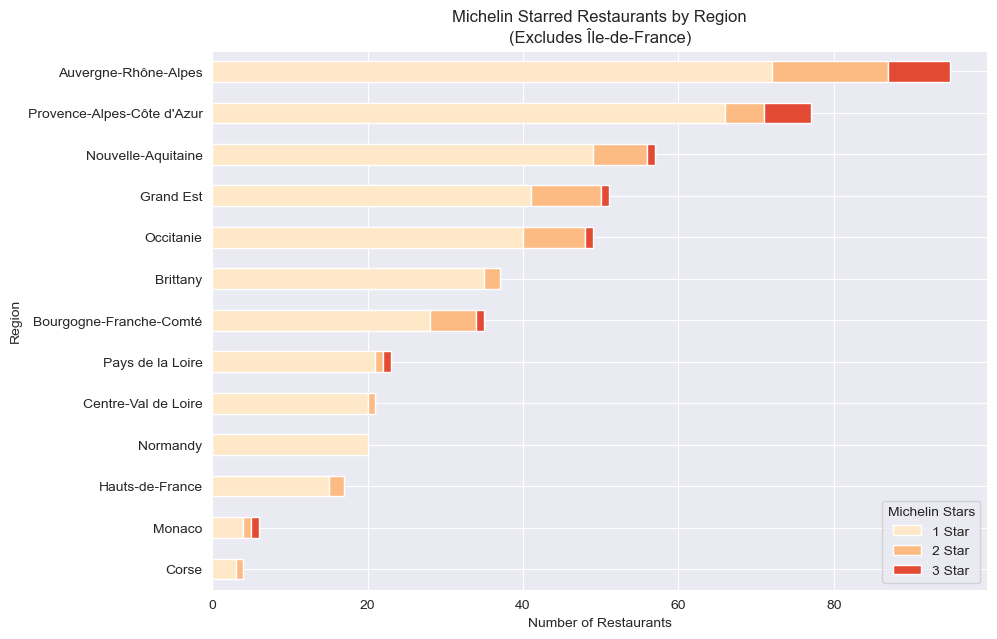

In [36]:
# Create a horizontal stacked bar plot
region_grouped_excl_paris.plot(kind='barh', stacked=True, figsize=(10, 7),
                    color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Michelin Starred Restaurants by Region\n(Excludes Île-de-France)')
plt.ylabel('Region')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

### By `department`

We group and plot the top 10 departments by total stars

In [37]:
# Group by 'department' and sum '1_star', '2_star' and '3_star'
dept_grouped = france_data.groupby(['department_num', 'department'])[['1_star', '2_star', '3_star']].sum()
dept_grouped_two = dept_grouped.copy()

# Create a 'total' column
dept_grouped['total_stars'] = dept_grouped['1_star']*1 + dept_grouped['2_star']*2 + dept_grouped['3_star']*3
dept_grouped_two['total'] = dept_grouped_two['1_star'] + dept_grouped['2_star'] + dept_grouped['3_star']

# Sort the dataframes by the 'department_num' column in descending order
dept_grouped.sort_values('department_num', ascending=True, inplace=True)
dept_grouped_two.sort_values('department_num', ascending=True, inplace=True)

In [38]:
# Exclude 'Paris'
dept_grouped_no_paris = dept_grouped_two[dept_grouped_two.index.get_level_values('department').str.strip() != 'Paris']

In [39]:
# Sort by 'total' in descending order and keep the top 10
dept_grouped_top10 = dept_grouped_no_paris.sort_values('total', ascending=False).head(10)

# Drop the 'total' column
dept_grouped_top10 = dept_grouped_top10.drop(columns=['total'])

# Reverse the order of the DataFrame
dept_grouped_top10 = dept_grouped_top10.iloc[::-1]

Plot the data

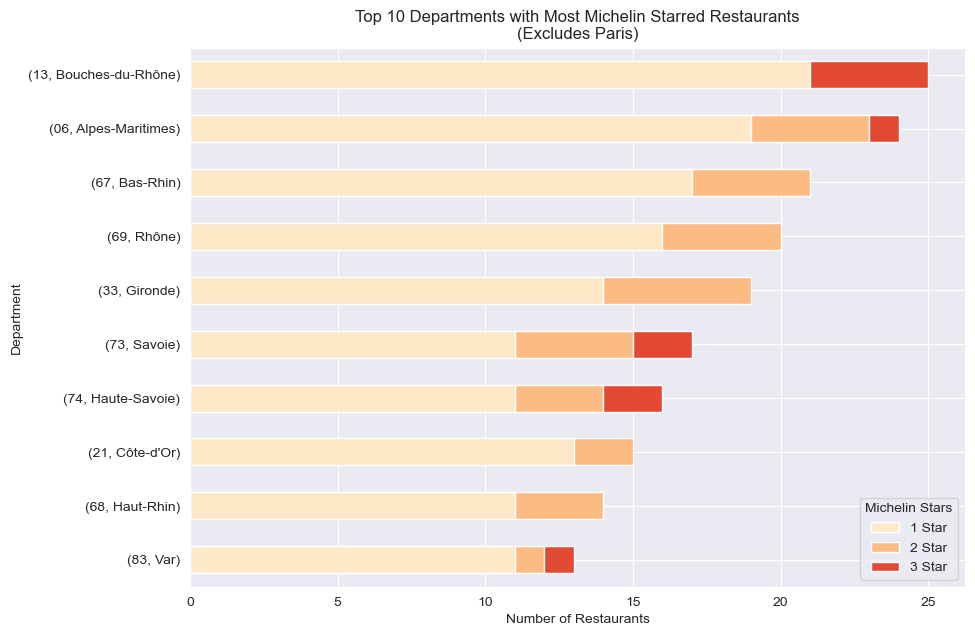

In [40]:
# Plot the data
dept_grouped_top10.plot(kind='barh', stacked=True, figsize=(10, 7),
                        color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Top 10 Departments with Most Michelin Starred Restaurants\n(Excludes Paris)')
plt.ylabel('Department')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

----
&nbsp;
## Merging Michelin stars by `department` & `region` with the population demographics data

In [41]:
print(f"Rows in `demographics`: {len(demographics)}")

# We index the multi-indexed df
dept_grouped.reset_index(inplace=True)
print(f"Rows in `dept_grouped`: {len(dept_grouped)}")

Rows in `demographics`: 96
Rows in `dept_grouped`: 92


There are some discrepancies

In [42]:
set1 = set(dept_grouped['department'].unique())
set2 = set(demographics['department'].unique())
print(set1 == set2)  # This should print True if all sets are equal

False


In [43]:
print("In dept_grouped but not in demographics: ", set1 - set2)
print("In demographics but not in dept_grouped: ", set2 - set1)

In dept_grouped but not in demographics:  {'Corse', 'Monaco'}
In demographics but not in dept_grouped:  {'Deux-Sèvres', 'Nièvre', 'Tarn-et-Garonne', 'Haute-Corse', 'Corse-du-Sud', 'Aisne'}


The two Corsican departments will be merged to `Corse` in `demographics`

`Monaco` will be dropped from `dept_grouped`

The remaining four departments were not present in the original import `france_data.csv` as they had neither bibs nor stars.
Therefore, we will write them to `dept_grouped` with zero values

In [44]:
# Create a copy as `demographics` will also be used for the regional data
demographics_copy = demographics.copy()

In [45]:
# Remove Monaco
dept_grouped = dept_grouped[dept_grouped['department'] != 'Monaco']

Appending missing departments to `dept_grouped`

In [46]:
# Missing departments in `dept_grouped`
missing_dept_dict = {'Deux-Sèvres': '79', 'Nièvre': '58', 'Aisne': '02', 'Tarn-et-Garonne': '82'}

for dept in missing_dept_dict:
    dept_data = pd.Series({'department_num': missing_dept_dict[dept],
                           'department': dept, '1_star': 0, '2_star': 0, '3_star': 0, 'total_stars': 0})
    dept_grouped = pd.concat([dept_grouped, pd.DataFrame([dept_data])], ignore_index=True)

We combine the two Corsican departments in `demographics`

In [47]:
corse_data = demographics[(demographics['department'] == 'Haute-Corse') |
                          (demographics['department'] == 'Corse-du-Sud')].sum(numeric_only=True)

corse_data['department_num'] = '20'
corse_data['department'] = 'Corse'
corse_data['region'] = 'Corse'

demographics = pd.concat([demographics, pd.DataFrame(corse_data).T], ignore_index=True)
# We drop 'Haute-Corse' and 'Corse-du-Sud' from demographics
demographics = demographics[(demographics['department'] != 'Haute-Corse')
                            & (demographics['department'] != 'Corse-du-Sud')]

In [48]:
set1 = set(dept_grouped['department'].unique())
set2 = set(demographics['department'].unique())
print(set1 == set2)  # This should print True if all sets are equal

True


No discrepancies. We merge the dataframes

In [49]:
# Sort dataframes on 'department_num'
dept_grouped = dept_grouped.sort_values('department_num')
demographics = demographics.sort_values('department_num')

In [50]:
# Merge demographics data with department data
departmental_data = dept_grouped.merge(demographics, how='inner', on='department_num')

In [51]:
print(departmental_data.columns.tolist())

['department_num', 'department_x', '1_star', '2_star', '3_star', 'total_stars', 'department_y', 'region', 'population', 'population_density', 'area_sq_km']


In [52]:
# Drop 'department_y' column
departmental_data = departmental_data.drop('department_y', axis=1)

# Rename 'department_x' to 'department'
departmental_data = departmental_data.rename(columns={'department_x': 'department'})

# Order columns
departmental_data = departmental_data[['department_num', 'department', 'region', '1_star', '2_star', '3_star',
                                       'total_stars','population', 'population_density', 'area_sq_km']]

In [53]:
departmental_data.head()

,department_num,department,region,1_star,2_star,3_star,total_stars,population,population_density,area_sq_km
0,01,Ain,Auvergne-Rhône-Alpes,4,0,1,7,652432,114.2,5713.06
1,02,Aisne,Hauts-de-France,0,0,0,0,531345,71.9,7390.06
2,03,Allier,Auvergne-Rhône-Alpes,2,0,0,2,335975,45.7,7351.75
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,3,0,0,3,164308,23.9,6874.81
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,1,0,0,1,141220,25.3,5581.82


In [54]:
departmental_data.shape

(95, 10)

----
&nbsp;
### Merging `region_grouped` with `demographics`

We first need to sum the population by region in `demographics`

In [55]:
# Group the demographics data by 'region' and sum all the numerical data
grouped_demographics = demographics_copy.groupby('region').sum()

# We index the multi-indexed df
grouped_demographics.reset_index(inplace=True)

# We replace 'Corsica' with 'Corse' to match `region_grouped`
grouped_demographics['region'] = grouped_demographics['region'].replace('Corsica', 'Corse')

In [56]:
# Merge demographics data with department data
regional_data = region_grouped.merge(grouped_demographics, how='inner', on='region')
regional_data

,region,1_star,2_star,3_star,total_stars,population,population_density,area_sq_km
0,Corse,3,1,0,5,340440,79.3,8593.94
1,Hauts-de-France,15,2,0,19,6004947,979.0,31864.47
2,Normandy,20,0,0,20,3325032,554.5,29892.65
3,Centre-Val de Loire,20,1,0,22,2573180,399.7,39169.91
4,Pays de la Loire,21,1,1,26,3806461,579.4,31916.44
5,Brittany,35,2,0,39,3354854,496.7,27059.42
6,Bourgogne-Franche-Comté,28,6,1,43,2805580,629.8,47874.19
7,Occitanie,40,8,1,59,5933185,1058.5,72420.70
8,Grand Est,41,9,1,62,5556219,1059.4,57465.76
9,Nouvelle-Aquitaine,49,7,1,66,6010289,815.2,83858.63


We have lost `Monaco` with this merge. *"C'est pas grave"*

----
&nbsp;
## Visualisations of population/restaurant concentration